In [15]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Use a small sample to test (10k points)

In [2]:
df = pd.read_parquet("../data/qsc_out.random_scan_nfp2.parquet").sample(10000)

In [3]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,y0,y1,y2,y3,y4,y5,y6
540776,-0.205011,-0.011042,-0.024465,-0.000120,-0.009828,0.023918,-0.100643,-2.563239,0.167271,26.037857,1.255791,30.403030,5.506516,17.264242,0.394376
134181,0.151174,0.275242,0.014049,0.041831,-0.000670,-0.000205,-0.223343,-0.089028,3.082412,3.378304,3.415675,6.543945,1.949376,5.417538,0.347391
449014,0.017982,0.239972,0.000291,0.032588,-0.006905,-0.000467,-1.218774,-13.168492,13.985917,36.636635,4.260750,3.009024,1.854550,3.439345,0.305390
975956,-0.103016,0.124013,-0.006606,0.012147,-0.002938,0.006035,-1.117954,-12.157849,0.624831,96.262573,81.453857,2.936492,3.312693,176.377609,0.338051
181467,0.087031,0.300399,0.005140,0.049052,-0.006324,-0.001100,-0.315488,0.505636,1.607209,5.456250,8.558985,5.045418,2.502362,5.390345,0.324522


In [4]:
y_columns = [col for col in df.columns if col.startswith('y')]

In [5]:
Y = df[y_columns]
Y.head()

,y0,y1,y2,y3,y4,y5,y6
540776,0.167271,26.037857,1.255791,30.403030,5.506516,17.264242,0.394376
134181,3.082412,3.378304,3.415675,6.543945,1.949376,5.417538,0.347391
449014,13.985917,36.636635,4.260750,3.009024,1.854550,3.439345,0.305390
975956,0.624831,96.262573,81.453857,2.936492,3.312693,176.377609,0.338051
181467,1.607209,5.456250,8.558985,5.045418,2.502362,5.390345,0.324522


# Plot an histogram

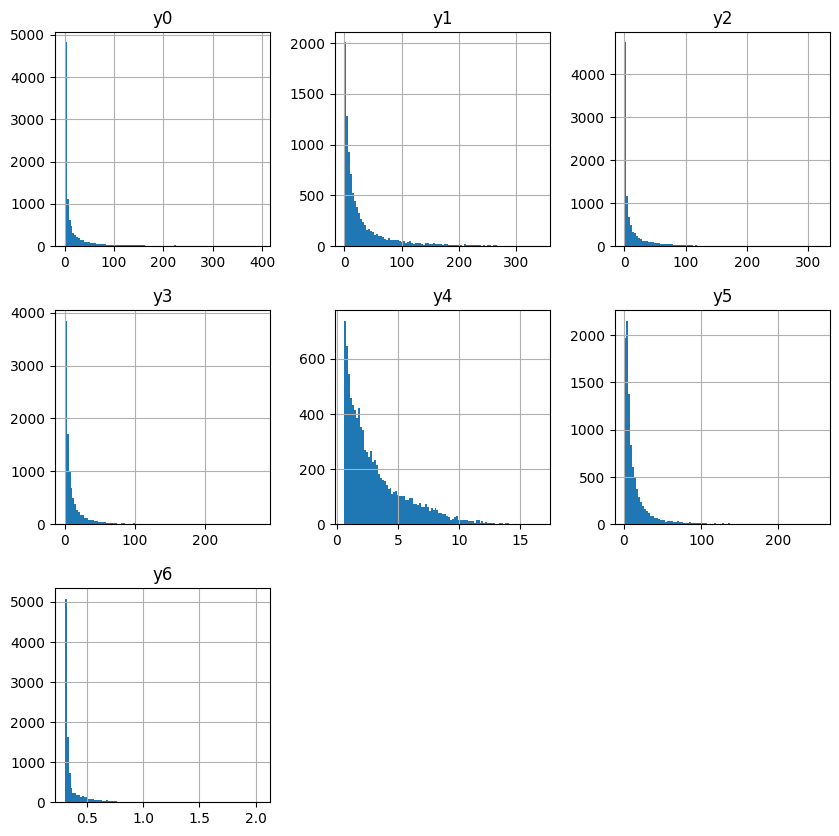

In [6]:
Y.hist(bins=100, figsize=(10,10));

In [7]:
Y.shape

(10000, 7)

# Train test split

In [8]:
train_data, test_data = train_test_split(Y, test_size=0.2, random_state=42)

# Use scikit pipeline to test number of components

In [9]:
# Define the pipeline
pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('gmm', GaussianMixture(random_state=1337))
])

In [14]:
# List to store BIC values
bic_values = []

# Fit a GMM and compute BIC for each number of components from 1 to 50
for i in range(1, 50):
    print(f"Fitting {i} component")
    pipeline.set_params(gmm__n_components=i)
    pipeline.fit(train_data)
    bic_values.append(pipeline['gmm'].bic(pipeline['scaling'].transform(test_data)))
    print(f"The BIC value is {bic_values[i-1]}")

Fitting 1 component
The BIC value is 36029.385758842865
Fitting 2 component
The BIC value is 18621.899972660787
Fitting 3 component
The BIC value is 13346.35767522361
Fitting 4 component
The BIC value is 10032.842580922234
Fitting 5 component


KeyboardInterrupt: 

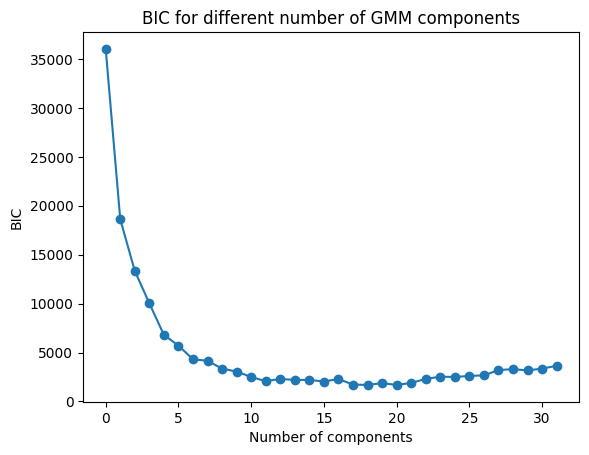

Best number of components based on BIC: 19


In [13]:
# Plot BIC values to visualize the best number of components
plt.plot(range(0, len(bic_values)), bic_values, marker='o')
plt.title('BIC for different number of GMM components')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.show()

# Select the number of components with the lowest BIC
best_n_components = np.argmin(bic_values) + 1
print(f'Best number of components based on BIC: {best_n_components}')

In [25]:
pipeline.set_params(gmm__n_components=19)
pipeline.fit(train_data)

Pipeline(steps=[('scaling', StandardScaler()),
                ('gmm', GaussianMixture(n_components=19, random_state=1337))])

In [97]:
# Prepare a list to hold the samples
samples = []

number_of_samples = 10000

# Continue sampling until we have 10k samples with values > 0
while len(samples) < number_of_samples:
    # Sample a batch of 1000 samples at once for efficiency
    batch = pipeline.steps[0][1].inverse_transform(pipeline.steps[1][1].sample(10000)[0])
    # Filter out samples with values <= 0
    batch = batch = batch[np.all(batch > 0, axis=1)]
    # Append the valid samples to our list
    samples.extend(batch)

# Truncate the list to exactly 10k samples
samples = samples[:number_of_samples]

# Convert the list to a numpy array for convenience
samples = np.array(samples)

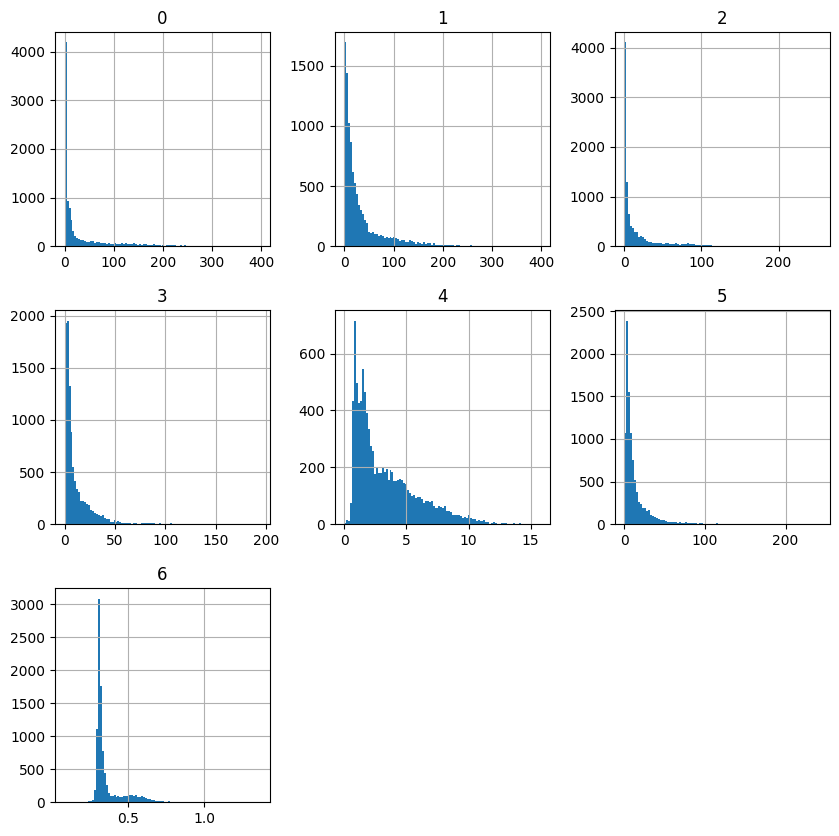

In [98]:
pd.DataFrame(samples).hist(bins=100, figsize=(10,10));